In [2]:

import pandas as pd

# Cargar el archivo CSV subido
df = pd.read_csv('diabetes_dataset_with_notes.csv')

# Verificación de estructura general
#info = df.info()
#missing = df.isnull().sum()
#head = df.head()


#info, missing, head


En el desarrollo del entendimiento de los datos, pudimos visualizar que: 
Contiene 100K filas y 17 Columnas  incluyendo información sobre: gender, age, location, race, hypertension, heart disease, smoking history, BMI, HbA1c level, blood glucose level, and diabetes status. y su variable objetivo (Binaria: 0= no, 1= si)


**VARIABLES**: 


**Numéricas:** age, bmi, hbA1c_level (hemoglobina glicosilada), blood_glucose_level

**Categóricas (object):** gender, location, smoking_history

**One-hot encoding ya hecho para raza:** columnas race [AfricanAmerica, Asian, Caucasian, Hispanic, Other]

**Target:** diabetes (int64)

**Texto libre:** clinical_notes (podemos excluirlo por ahora)



Limpieza y transformación

Eliminación de columnas irrelevantes para los modelos

In [3]:
df_model = df.drop(columns=["clinical_notes", "year", "location"])

Codificarción de las variables catergóricas gender (Male=0, Female=1) y Smoking_history donde establece el historia de fumar con 6 categorias ("never", "former", "current", "ever", "not current", "No Info"); quedando con 5 y evitando la multicolinealidad.

In [4]:
df_model['gender'] = df_model['gender'].map({'Female': 1, 'Male': 0})
df_model = pd.get_dummies(df_model, columns=['smoking_history'], drop_first=True)

Valores nulos encontrados en la columna gender del dataset

In [5]:
print(df_model['gender'].unique())
df_model['gender'].isna().sum()
#df_model.isna().sum()

[ 1.  0. nan]


18

Porcentaje de valores nan

In [6]:
porcentaje_nan_gender = df_model['gender'].isna().sum() / len(df_model) * 100
print(f"Porcentaje de NaN en 'gender': {porcentaje_nan_gender:.4f}%")


Porcentaje de NaN en 'gender': 0.0180%


Debido al pequeño porcentaje equivalente al 0.018%, se decide optar por la eliminación de los valores nulos

In [7]:
df_model = df_model.dropna(subset=['gender'])

In [8]:
print(df_model['gender'].unique())
df_model['gender'].isna().sum()

[1. 0.]


0

Estadística

In [9]:
desc = df_model.describe()
#print(desc)

Distribución de la variable objetivo

In [10]:
target_distribution = df_model['diabetes'].value_counts()
target_percent = df_model['diabetes'].value_counts(normalize=True) * 100
target_percent

diabetes
0    91.49847
1     8.50153
Name: proportion, dtype: float64

Variables Predictoras

In [11]:
X = df_model.drop('diabetes', axis=1)
y = df_model['diabetes']


Librerias para visualización

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


**Visualización de la clase objetivo**

Matriz de correlación

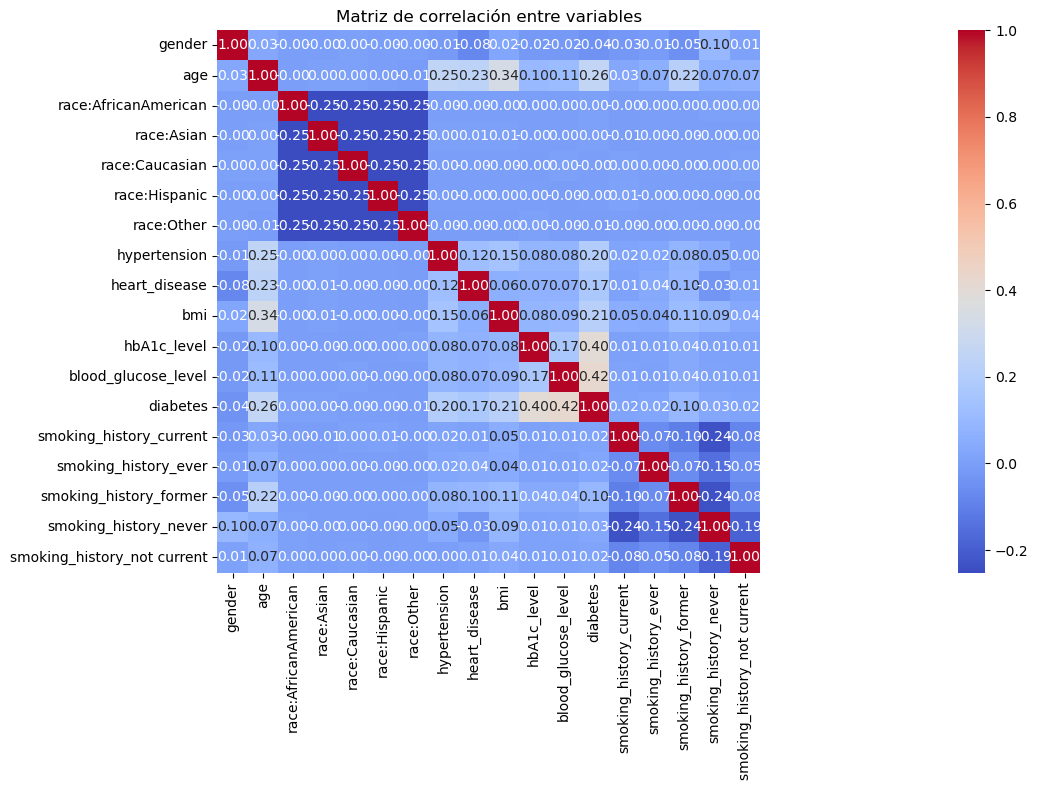

In [13]:
plt.figure(figsize=(40, 8))
sns.heatmap(df_model.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de correlación entre variables")
plt.tight_layout()
plt.show()

In [14]:
df_model.head()

,gender,age,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,bmi,hbA1c_level,blood_glucose_level,diabetes,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,1.0,32.0,0,0,0,0,1,0,0,27.32,5.0,100,0,False,False,False,True,False
1,1.0,29.0,0,1,0,0,0,0,0,19.95,5.0,90,0,False,False,False,True,False
2,0.0,18.0,0,0,0,0,1,0,0,23.76,4.8,160,0,False,False,False,True,False
3,0.0,41.0,0,0,1,0,0,0,0,27.32,4.0,159,0,False,False,False,True,False
4,1.0,52.0,1,0,0,0,0,0,0,23.75,6.5,90,0,False,False,False,True,False


In [15]:
print(df_model['hypertension'].unique())
print(df_model['heart_disease'].unique())

[0 1]
[0 1]


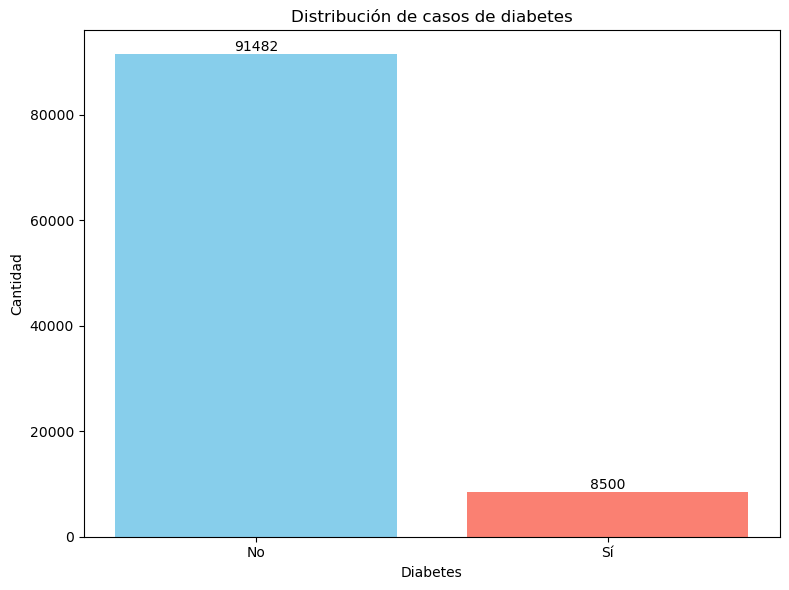

In [16]:
plt.figure(figsize=(8, 6))
bars = plt.bar([0, 1], df_model['diabetes'].value_counts(), color=['skyblue', 'salmon'])
plt.bar_label(bars)
plt.xticks(ticks=[0, 1], labels=['No', 'Sí'], rotation=0)
plt.xlabel('Diabetes')
plt.ylabel('Cantidad')
plt.title('Distribución de casos de diabetes')
plt.tight_layout()
plt.show()

Esto confirma que el dataset está fuertemente desbalanceado, lo que puede afectar a la clase minoritaria

<div style="background-color:#042034; border-left: 6px solid #007bff; padding: 10px; margin-bottom: 20px;">
  <h1 style="margin:0;"> ⚖️BLANCE DEL DATASET</h1>
</div>

In [17]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

Dividir los datos en entrenamiento y prueba

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

Aplicación de RandomUnderSampler SMOTE, aplicamos esta técnica híbrida con el fin de no tener que reducir tanto la clase mayoritaria o aumentar mucho la minoritaria.

In [19]:
# Primer reduce
under = RandomUnderSampler(sampling_strategy=0.4, random_state=42)

# Luego aumenta
smote = SMOTE(sampling_strategy=0.8, random_state=42)

pipeline = Pipeline(steps=[('u', under), ('o', smote)])

X_train_bal, y_train_bal = pipeline.fit_resample(X_train, y_train)

Resultados del balance

In [20]:
print("Distribución original:\n", y_train.value_counts())
print("Distribución balanceada:\n", y_train_bal.value_counts())

Distribución original:
 diabetes
0    64037
1     5950
Name: count, dtype: int64
Distribución balanceada:
 diabetes
0    14875
1    11900
Name: count, dtype: int64


<div style="background-color:#042034; border-left: 6px solid #007bff; padding: 10px; margin-bottom: 20px;">
  <h1 style="margin:0;">🌲 ÁRBOL DE DECISIÓN </h1>
</div>

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

Creación y entrenamiento del modelo

In [22]:
dt = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42)
dt.fit(X_train_bal, y_train_bal)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)

Predicciones sobre el conjunto de prueba

In [23]:
#Hacer predicciones con el conjunto de prueba original
y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)[:, 1]  # Probabilidad para AUC

Evaluación del modelo

📊 Evaluación - Árbol de Decisión:

  Métrica  Valor
 Accuracy  0.863
Precision  0.375
   Recall  0.920
 F1-score  0.533
      AUC  0.960


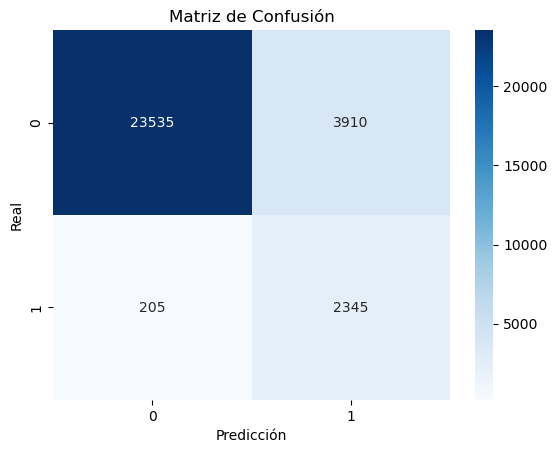

In [24]:

accuracy = round(accuracy_score(y_test, y_pred_dt), 3)
report = classification_report(y_test, y_pred_dt, output_dict=True)
precision = round(report['1']['precision'], 3)
recall = round(report['1']['recall'], 3)
f1 = round(report['1']['f1-score'], 3)
auc = round(roc_auc_score(y_test, y_prob_dt), 3)

# Mostrar métricas en tabla pequeña
df_metrics = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC'],
    'Valor': [accuracy, precision, recall, f1, auc]
})

print("📊 Evaluación - Árbol de Decisión:\n")
print(df_metrics.to_string(index=False))


#Matriz de confusión
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

<div style="background-color:#062f4c; border-left: 6px solid #007bff; padding: 10px; margin-bottom: 20px;">
  <h2 style="margin:0;"> 🔶 Gráfica del árbol de decisión</h2>
</div>

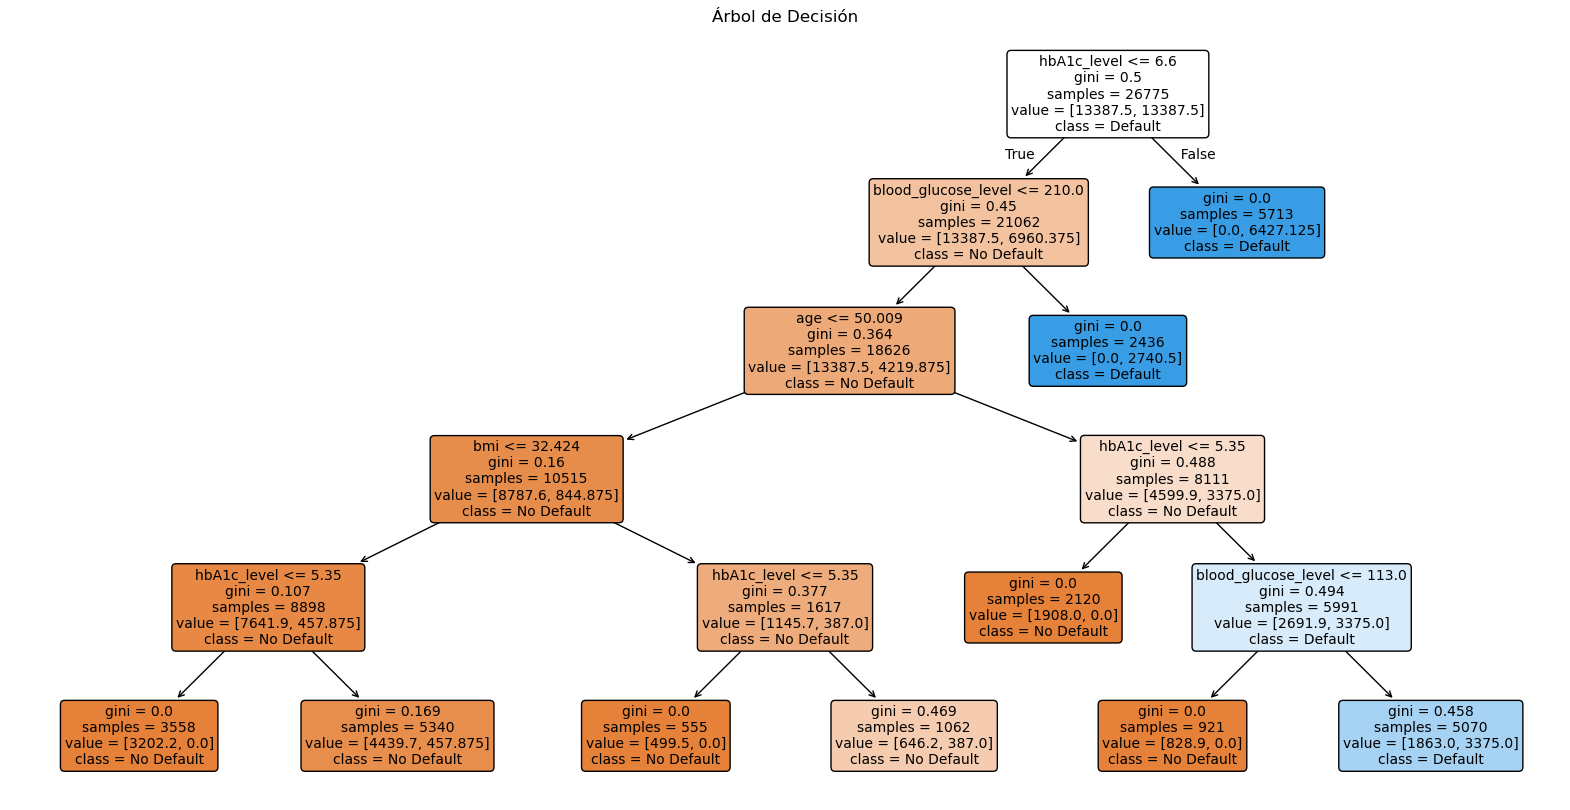

In [25]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))  # Tamaño grande para visualizar bien
plot_tree(
    dt,
    filled=True,              # Colores por clase
    feature_names=X_train_bal.columns,  # Nombres de las variables
    class_names=["No Default", "Default"],  # Nombres de las clases
    rounded=True,
    fontsize=10
)
plt.title("Árbol de Decisión")
plt.show()


<div style="background-color:#042034; border-left: 6px solid #007bff; padding: 10px; margin-bottom: 20px;">
  <h1 style="margin:0;">🌲🌲🌲 RANDOM FOREST</h1>
</div>

Creación y entrenamiento del modelo

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train_bal, y_train_bal)


RandomForestClassifier(class_weight='balanced', random_state=42)

Predicciones sobre el conjunto de prueba

In [28]:
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

Evaluación del modelo

📊 RANDOM FOREST:

  Métrica  Valor
 Accuracy  0.939
Precision  0.604
   Recall  0.822
 F1-score  0.696
      AUC  0.972


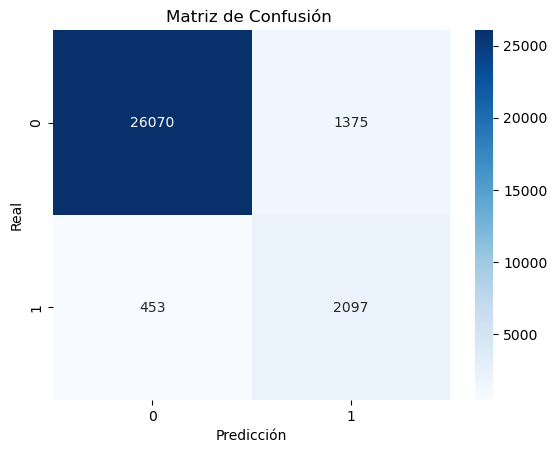

In [29]:
accuracy = round(accuracy_score(y_test, y_pred_rf), 3)
report = classification_report(y_test, y_pred_rf, output_dict=True)
precision = round(report['1']['precision'], 3)
recall = round(report['1']['recall'], 3)
f1 = round(report['1']['f1-score'], 3)
auc = round(roc_auc_score(y_test, y_prob_rf), 3)

# Mostrar métricas en tabla pequeña
df_metrics = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC'],
    'Valor': [accuracy, precision, recall, f1, auc]
})

print("📊 RANDOM FOREST:\n")
print(df_metrics.to_string(index=False))


#Matriz de confusión
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión ")
plt.show()

/home/fernando/anaconda3/envs/mlpy/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


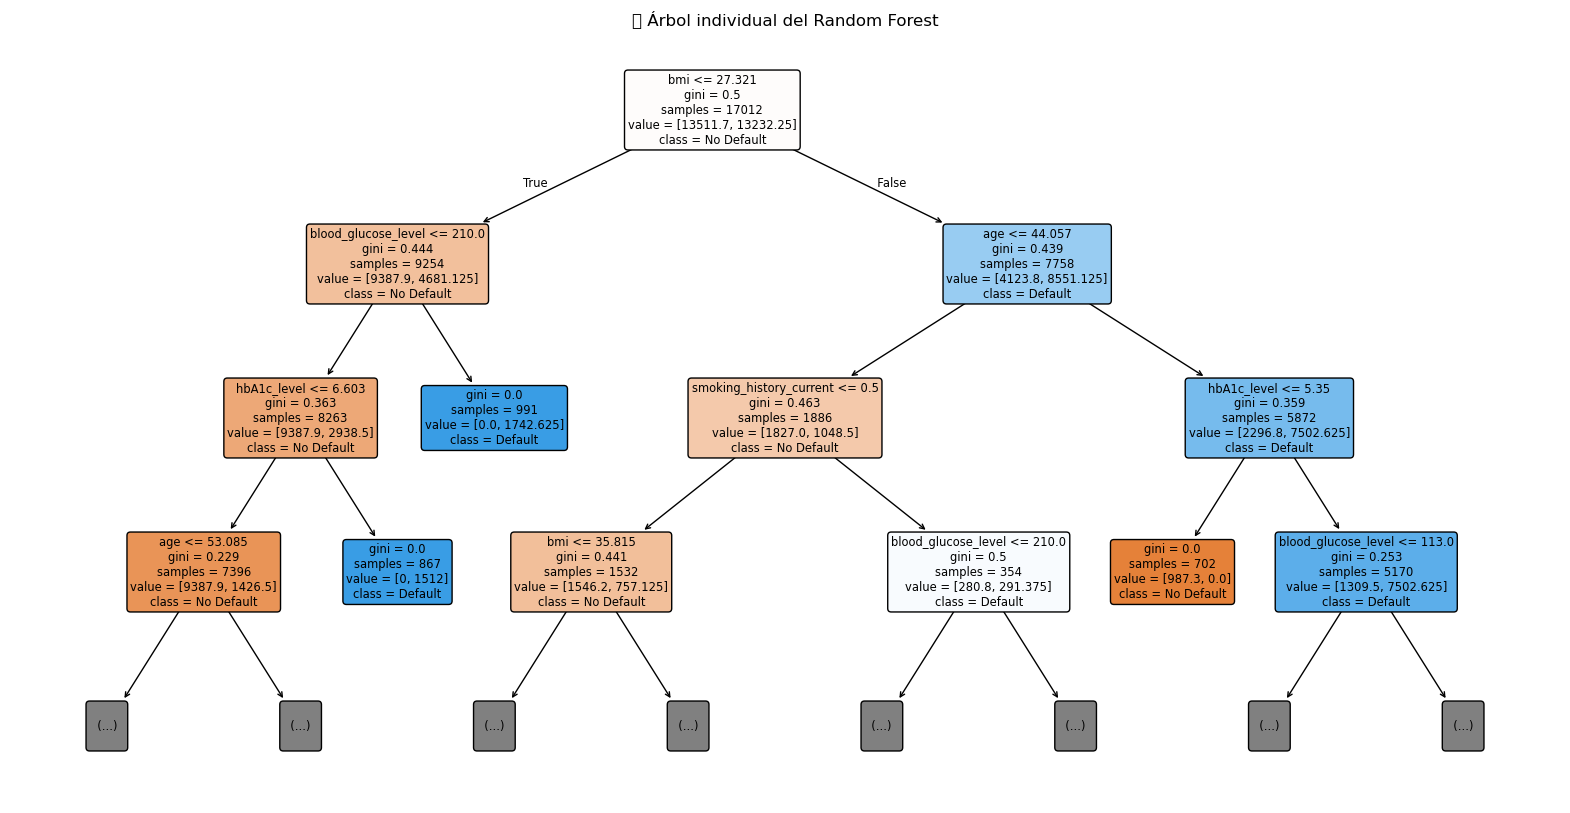

In [30]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Elegimos uno de los árboles del bosque
arbol_individual = rf.estimators_[0]  # Primer árbol del Random Forest

plt.figure(figsize=(20, 10))
plot_tree(
    arbol_individual,
    filled=True,
    feature_names=X_train.columns,
    class_names=["No Default", "Default"],
    rounded=True,
    max_depth=3  # Para que no sea gigante
)
plt.title("🌲 Árbol individual del Random Forest")
plt.show()


<div style="background-color:#042034; border-left: 6px solid #007bff; padding: 10px; margin-bottom: 20px;">
  <h1 style="margin:0;">🚀 XGBoost</h1>
</div>

Creación y entrenamiento del modelo

In [31]:
from xgboost import XGBClassifier

In [32]:
xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    scale_pos_weight=(y_train_bal.value_counts()[0] / y_train_bal.value_counts()[1]),  # ajustar desbalance
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train_bal, y_train_bal)

/home/fernando/anaconda3/envs/mlpy/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:54:03] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Predicciones sobre el conjunto de prueba

In [33]:
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

Evaluación del modelo

📊 Evaluación - Árbol de Decisión:

  Métrica  Valor
 Accuracy  0.927
Precision  0.542
   Recall  0.880
 F1-score  0.671
      AUC  0.977


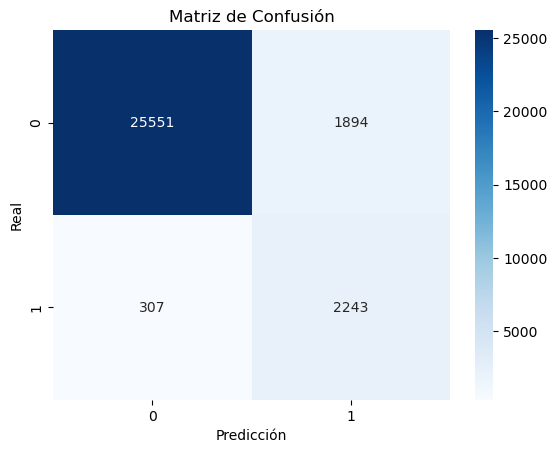

In [34]:
accuracy = round(accuracy_score(y_test, y_pred_xgb), 3)
report = classification_report(y_test, y_pred_xgb, output_dict=True)
precision = round(report['1']['precision'], 3)
recall = round(report['1']['recall'], 3)
f1 = round(report['1']['f1-score'], 3)
auc = round(roc_auc_score(y_test, y_prob_xgb), 3)

# Mostrar métricas en tabla pequeña
df_metrics = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC'],
    'Valor': [accuracy, precision, recall, f1, auc]
})

print("📊 Evaluación - Árbol de Decisión:\n")
print(df_metrics.to_string(index=False))


#Matriz de confusión
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

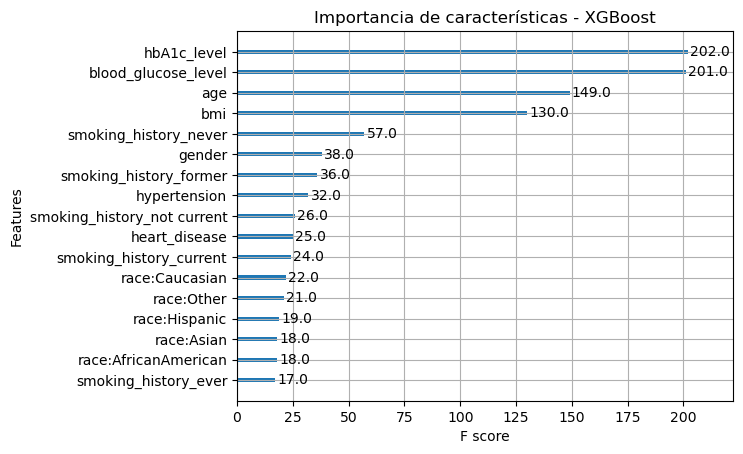

In [35]:
from xgboost import plot_importance

plot_importance(xgb)
plt.title("Importancia de características - XGBoost")
plt.show()


<div style="background-color:#042034; border-left: 6px solid #007bff; padding: 10px; margin-bottom: 20px;">
  <h1 style="margin:0;">📏 Estandarizar los datos</h1>
</div>

Para modelos como **redes neuronales** o **máquinas de soporte vectorial** es necesario estandarizar los datos, ya que estos métodos son sensibles a la escala de los datos. Al tener variables categóricas, es necesario usar `ColumnTransformer`.

In [36]:
#Importar librerías para estadarizar los datos
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

<div style="background-color:#062f4c; border-left: 6px solid #007bff; padding: 10px; margin-bottom: 20px;">
  <h2 style="margin:0;"> 🔶 Definición de las columnas Categóricas y Numéricas</h2>
</div>

Se definen las variables categóricas y numéricas, a las categóricas no se les aplica la estandarización.

In [37]:
continuous_cols = ['age', 'bmi','hbA1c_level', 'blood_glucose_level']

cat_cols = ['gender','race:AfricanAmerican', 'race:Asian', 'race:Caucasian',
       'race:Hispanic', 'race:Other', 'hypertension', 'heart_disease', 'smoking_history_current', 'smoking_history_ever',
       'smoking_history_former', 'smoking_history_never',
       'smoking_history_not current']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols),
        ('cat', 'passthrough', cat_cols)
    ]
)
 

In [38]:
#Escalar datos de entrenamiento y guardar el escalador
X_train_scaled = preprocessor.fit_transform(X_train_bal)

#Escalar datos de prueba
X_test_scaled = preprocessor.transform(X_test)


<div style="background-color:#042034; border-left: 6px solid #007bff; padding: 10px; margin-bottom: 20px;">
  <h1 style="margin:0;">🤖 Máquinas de Soporte Vectorial</h1>
</div>

Una máquina de vectores de soporte (SVM) es un algoritmo de machine learning supervisado que clasifica los datos mediante la búsqueda de una línea o un hiperplano óptimos que maximice la distancia entre cada clase en un espacio N-dimensional.

![alt text](https://www.iunera.com/wp-content/uploads/image-16-1024x756.png?v=1596602837)
![alt text](https://cdn.botpenguin.com/assets/website/Screenshot_2024_02_27_at_3_29_43_PM_1_8e43969a35.webp) 

In [39]:
#Importar librería para clasificador SVM
from sklearn.svm import SVC

In [40]:
#Definir y entrenar el modelo
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train_scaled, y_train_bal)

SVC(random_state=42)

In [41]:
#Evaluar el modelo con los datos de prueba
y_pred_svm = svm_model.predict(X_test_scaled)

In [42]:
y_prob_svm = svm_model.decision_function(X_test_scaled)

              precision    recall  f1-score   support

           0       0.98      0.95      0.96     27445
           1       0.58      0.81      0.68      2550

    accuracy                           0.93     29995
   macro avg       0.78      0.88      0.82     29995
weighted avg       0.95      0.93      0.94     29995



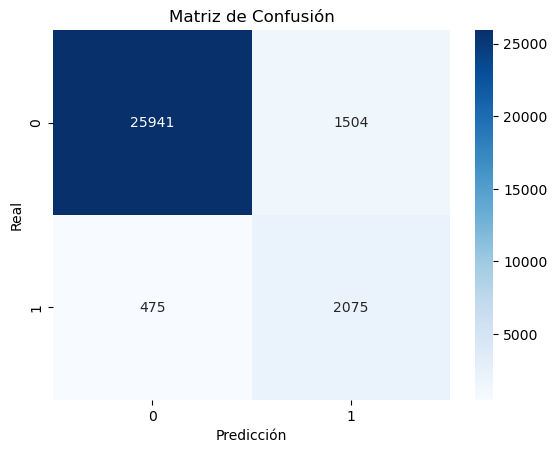

In [43]:
# Reporte de métricas
print(classification_report(y_test, y_pred_svm))

# Matriz de confusión
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

<div style="background-color:#042034; border-left: 6px solid #007bff; padding: 10px; margin-bottom: 20px;">
  <h1 style="margin:0;">🧠 Redes Neuronales (Multi Layer Perceptron)</h1>
</div>

Para aplicar las redes neuronales definimos el conjunto de validación, el cual servirá para detener el entrenamiento cuando sea necesario.

In [44]:
X_test_mlp, X_val_mlp, y_test_mlp, y_val_mlp = train_test_split(X_test_scaled, y_test, test_size=0.5, random_state=42)

In [45]:
print(X_train_scaled.shape)
print(y_train_bal.shape) 
print(X_test_mlp.shape)
print(X_val_mlp.shape)

(26775, 17)
(26775,)
(14997, 17)
(14998, 17)


In [46]:
#Importar librerías para crear la red neuronal
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.callbacks import EarlyStopping


2025-03-30 10:54:16.097280: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-30 10:54:16.156875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-30 10:54:16.170937: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-30 10:54:16.174700: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-30 10:54:16.235316: I tensorflow/core/platform/cpu_feature_guar

<div style="background-color:#062f4c; border-left: 6px solid #007bff; padding: 10px; margin-bottom: 20px;">
  <h2 style="margin:0;"> 🔶 Creación del modelo</h2>
</div>

Al crear el modelo usamos la función de activación `Gelu`. Esta función es no monótona debido a que tiene una ligera curva, esto le permite al modelo aprender funciones más complejas.

![all text](https://miro.medium.com/v2/resize:fit:794/1*HKsrxYhE0cgGEk8TpBe44w.png)

In [47]:
# Limpiar el backend de Keras
K.clear_session()

# Crear el modelo

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1:])),
    tf.keras.layers.Dense(128, activation='gelu'),
    tf.keras.layers.Dense(64, activation='gelu'),
    tf.keras.layers.Dense(32, activation='gelu'),
    tf.keras.layers.Dense(16, activation='gelu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

I0000 00:00:1743350057.770528    1810 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1743350057.899553    1810 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1743350057.899592    1810 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1743350057.902290    1810 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1743350057.902321    1810 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [48]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,185 (51.50 KB)

 Trainable params: 13,185 (51.50 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
model.layers

[<Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>,
 <Dense name=dense_3, built=True>,
 <Dense name=dense_4, built=True>]

In [50]:
weigths, biases = model.layers[1].get_weights()
print(weigths)
print(weigths.shape)
print(biases)
print(biases.shape)

[[ 0.16856422 -0.16399466 -0.14369993 ...  0.06955835 -0.07951783
  -0.05500383]
 [-0.03989911 -0.14240295  0.14383604 ...  0.01639938 -0.00583157
   0.02029586]
 [-0.02658834 -0.17374578 -0.0918293  ... -0.16398408  0.1754307
  -0.04707985]
 ...
 [-0.15684718  0.1514384  -0.11423857 ...  0.1478763  -0.05733455
  -0.04061122]
 [ 0.03931855  0.0625882   0.15378918 ...  0.037304   -0.15206933
  -0.01123138]
 [-0.10243227 -0.15514036  0.03308557 ...  0.0874051  -0.01051509
  -0.06462081]]
(128, 64)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(64,)


In [51]:
#Compilar el modelo
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

In [52]:
X_train_scaled = np.array(X_train_scaled).astype(np.float32)
y_train_bal = np.array(y_train_bal).astype(np.float32)
X_test_mlp = np.array(X_test_mlp).astype(np.float32)
y_test_mlp = np.array(y_test_mlp).astype(np.float32)
X_val_mlp = np.array(X_val_mlp).astype(np.float32)
y_val_mlp = np.array(y_val_mlp).astype(np.float32)

In [53]:
#Agregar EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',       # Qué métrica observar
    patience= 5,               # Cuántas épocas esperar antes de detener
    restore_best_weights=True # Recuperar los mejores pesos
)


In [54]:
history = model.fit(X_train_scaled, y_train_bal, epochs=30,
                    validation_data=(X_val_mlp, y_val_mlp), callbacks=[early_stop])

Epoch 1/30


I0000 00:00:1743350059.293887    2271 service.cc:146] XLA service 0x7faf20013f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743350059.293915    2271 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2025-03-30 10:54:19.322937: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-30 10:54:19.415128: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


194/837 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - accuracy: 0.8476 - loss: 0.4030

I0000 00:00:1743350059.887616    2271 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


837/837 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8896 - loss: 0.2729 - val_accuracy: 0.8967 - val_loss: 0.2244
Epoch 2/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9175 - loss: 0.1710 - val_accuracy: 0.9361 - val_loss: 0.1377
Epoch 3/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9277 - loss: 0.1521 - val_accuracy: 0.9068 - val_loss: 0.1784
Epoch 4/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9305 - loss: 0.1446 - val_accuracy: 0.9417 - val_loss: 0.1307
Epoch 5/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9299 - loss: 0.1429 - val_accuracy: 0.9229 - val_loss: 0.1461
Epoch 6/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9308 - loss: 0.1430 - val_accuracy: 0.9331 - val_loss: 0.1412
Epoch 7/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9325 - loss: 0.1395 - val_accuracy: 0.9403 - val_loss: 0.1376
Epoch 8/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9326 - loss: 0.1366 - val_accuracy: 0.9283 - val_

<Axes: >

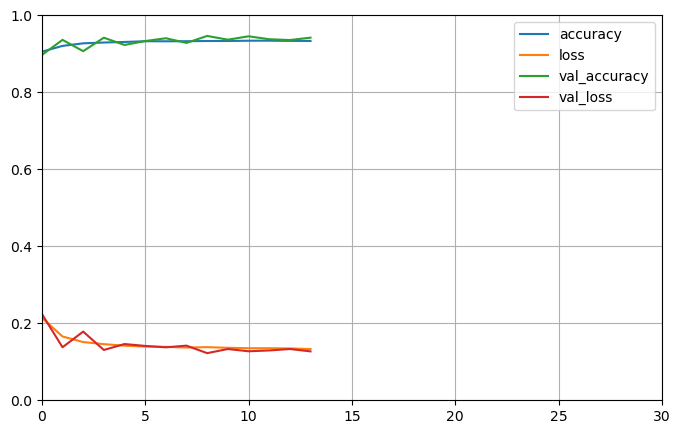

In [55]:
df_grafico = pd.DataFrame(history.history)
df_grafico.head()
df_grafico.plot(figsize=(8, 5), xlim = [0,30], ylim=[0, 1], grid=True)

In [56]:
model.evaluate(X_test_mlp, y_test_mlp)

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9471 - loss: 0.1207


[0.1190197765827179, 0.9497233033180237]

In [57]:
y_pred_mlp = (model.predict(X_test_mlp) > 0.5).astype("int32")

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step


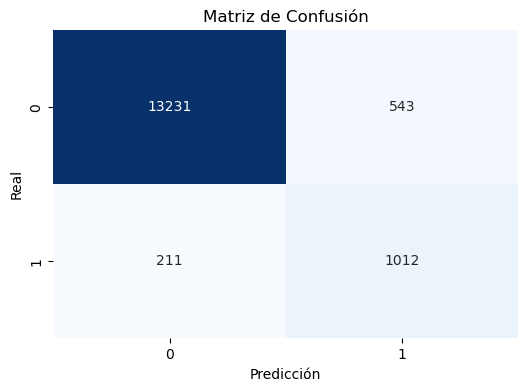

In [58]:
# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_test_mlp, y_pred_mlp)

# Mostrar la matriz como un heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

In [59]:
y_prob_mlp = model.predict(X_test_mlp).ravel()

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step


In [60]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [61]:
# Función para calcular métricas
def get_metrics(y_true, y_pred, y_prob):
    return {
        'Accuracy': round(accuracy_score(y_true, y_pred), 3),
        'Precision': round(precision_score(y_true, y_pred), 3),
        'Recall': round(recall_score(y_true, y_pred), 3),
        'F1-score': round(f1_score(y_true, y_pred), 3),
        'AUC': round(roc_auc_score(y_true, y_prob), 3)
    }

# Calcular métricas para cada modelo
metrics_dt = get_metrics(y_test, y_pred_dt, y_prob_dt)
metrics_rf = get_metrics(y_test, y_pred_rf, y_prob_rf)
metrics_xgb = get_metrics(y_test, y_pred_xgb, y_prob_xgb)
metrics_svm = get_metrics(y_test, y_pred_svm, y_prob_svm)
metrics_mlp = get_metrics(y_test_mlp, y_pred_mlp, y_prob_mlp)

# Crear DataFrame comparativo
df_comparacion = pd.DataFrame({
    'Árbol de Decisión': metrics_dt,
    'Random Forest': metrics_rf,
    'XGBoost': metrics_xgb,
    'Máquina de soporte vectorial': metrics_svm,
    'Multi Layer Perceptron': metrics_mlp,
})

# Transponer para que cada modelo sea una fila
df_comparacion = df_comparacion.T
print("📊 Comparación de Modelos:\n")
print(df_comparacion)

📊 Comparación de Modelos:

                              Accuracy  Precision  Recall  F1-score    AUC
Árbol de Decisión                0.863      0.375   0.920     0.533  0.960
Random Forest                    0.939      0.604   0.822     0.696  0.972
XGBoost                          0.927      0.542   0.880     0.671  0.977
Máquina de soporte vectorial     0.934      0.580   0.814     0.677  0.955
Multi Layer Perceptron           0.950      0.651   0.827     0.729  0.976


In [62]:
from sklearn.metrics import roc_curve, auc


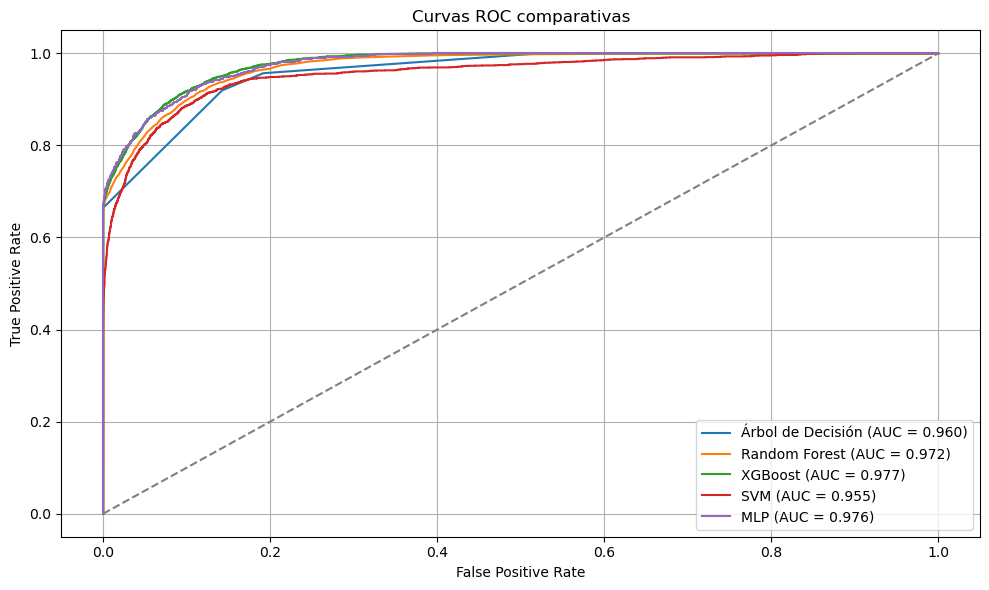

In [63]:
# Diccionario con nombre del modelo, y_test correcto y y_prob
model_roc_data = {
    'Árbol de Decisión': (y_test, y_prob_dt),
    'Random Forest': (y_test, y_prob_rf),
    'XGBoost': (y_test, y_prob_xgb),
    'SVM': (y_test, y_prob_svm),
    'MLP': (y_test_mlp, y_prob_mlp)  # 🔥 aquí está el cambio clave
}

# Inicializar gráfico
plt.figure(figsize=(10, 6))

# Dibujar curvas ROC
for name, (y_true, y_prob) in model_roc_data.items():
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

# Línea aleatoria
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Estética del gráfico
plt.title('Curvas ROC comparativas')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()



<div style="background-color:#042034; border-left: 6px solid #007bff; padding: 10px; margin-bottom: 20px;">
  <h1 style="margin:0;">💡 Conclusiones </h1>
</div>


- **Accuracy:** El mejor modelo en este apartado es el _MLP_ con un `94.8% ` aunque en general todos los modelos tienen un buen resultado, pero el *Accuracy* por si solo no es un buen indicador, principalmente cuando los datos están desbalanceados.

- **Recall:** El mejor modelo en este indicador es _Árbol de decisión_ con un `92%` este indicador es muy importante para el sector salud, ya que nos dice que tan bien se clasifican los resultados positivos, evitando los falsos negativos.

- **Precision:**  Aquí vemos que el mejor modelo en _Recall_ es el peor en la _precision_ lo que nos indica que está generando muchos falsos positivos. Por otro lado el modelo que mejor _precision_ tiene es _MLP_ con un `63.8%`.

- **F1-Score:** El modelo que brinda el mejor balance entre dtectar diabetes y los falsos positivos en _MLP_.

Si se busca un modelo robusto y equilibrado la mejor opción es _MLP_ ya que tiene una buena precisión clíninca y no compromete tanto la sensibilidad como otros modelos. Por otro lado si se requiere un modelo que clasifique los verdaderos positivos si importar el balance con los falsos positivos el mejor modelo es _Árbol de decisión_.